# ModelV2
## Object detection non-overlapping cards

In [1]:
!pip -q install ultralytics wandb


In [1]:
from ultralytics import YOLO
from jassair.utils.paths import get_dataset_path, Datasets
import wandb
import time
import torch
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

### Global variable definition

In [2]:
DATA_DIR = get_dataset_path(Datasets.SWISS)
BATCH_SIZE = 32
NUM_CLASSES = 36

In [3]:
torch.cuda.is_available()

True

Enable W&B logging for Ultralytics in CLI

`yolo settings wandb=True`

Disable Weights & Biases logging

`yolo settings wandb=False`

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aarfu (aarfu-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Model
We can use a singel YOLO model for both, object detection and classification tasks.

In [6]:
MODEL = YOLO("yolo11n.pt") # YOLOv11 nano for quick testing. Later we choose the larger model for better accuracy

## Train
imgsz: yolo resizes the input images to a square image. Since jasscards are not square, yolo resizes the long side to 640 and then scales the shorter side proportionally.

In [7]:
# Hyperparameters
# epochs=50
# imgsz=640 # 640 (default) – Balanced performance; 512 – Faster, lower memory usage, 1280+ – Best accuracy for small details but slower.
# iterations=100 # Number of tuning cycles (higher = better tuning). The model tries different values for lr, momentum, weight decay, etc.

HYPERPARAMETERS = {
    "lr0": 1e-3,        # renamed from "lr" to "lr0"
    "weight_decay": 1e-5,  # renamed from "wd"
    "imgsz": 640,
    "epochs": 100,
}

In [10]:
RUN_NAME = f"{time.strftime('%y%m%d-%H%M%S')}_{MODEL._get_name()}_lr{HYPERPARAMETERS['lr0']}"

In [11]:
wandb.init(
    entity="jassair",
    project="ModelV2",  # Specify project
    name=RUN_NAME, # Run name
    config=HYPERPARAMETERS,
)

When you choose iterations, the model tries to tune itself. Or you can tune them manually like below

In [13]:
# Model with all tunable hyperparameters
MODEL.train(
    data="/exchange/dspro2/jassair/data.yaml",
    device=0, # GPU
    batch=16,
    momentum=0.937,
    optimizer="SGD",
    project="jassair",
    name="test_run_1",
    patience=20,
    **HYPERPARAMETERS
)

Ultralytics 8.3.97 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/exchange/dspro2/jassair/data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=jassair, name=test_run_13, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /exchange/dspro2/jassair/data_v2.1/train/labels... 9994 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9994/9994 [00:07<00:00, 1358.23it/s]


train: New cache created: /exchange/dspro2/jassair/data_v2.1/train/labels.cache


val: Scanning /exchange/dspro2/jassair/data_v2.1/valid/labels... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:01<00:00, 1229.27it/s]


val: New cache created: /exchange/dspro2/jassair/data_v2.1/valid/labels.cache
Plotting labels to jassair/test_run_13/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=1e-05), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to jassair/test_run_13
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.31G     0.4831      3.685     0.9212         73        640: 100%|██████████| 625/625 [02:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]


                   all       2000       9002      0.305      0.476      0.265      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.7G     0.4287      2.245     0.8814         58        640: 100%|██████████| 625/625 [02:27<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


                   all       2000       9002       0.86      0.905       0.94      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.72G     0.3751      1.175     0.8572         73        640: 100%|██████████| 625/625 [02:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


                   all       2000       9002       0.99       0.99      0.994      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.73G     0.3438     0.7957     0.8453         57        640: 100%|██████████| 625/625 [02:30<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


                   all       2000       9002      0.995      0.993      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.74G     0.3259     0.6681       0.84         67        640: 100%|██████████| 625/625 [02:42<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000       9002      0.998      0.998      0.995      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.74G     0.3122       0.61     0.8368         77        640: 100%|██████████| 625/625 [02:46<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000       9002      0.998      0.999      0.995      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.75G     0.3039     0.5631     0.8345         68        640: 100%|██████████| 625/625 [02:31<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


                   all       2000       9002      0.998      0.999      0.995      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.76G     0.2977      0.533     0.8338         60        640: 100%|██████████| 625/625 [02:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]


                   all       2000       9002      0.997      0.999      0.995      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.77G     0.2905     0.5083      0.833         60        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]


                   all       2000       9002      0.999      0.999      0.995      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.77G      0.285     0.4885     0.8321         56        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]


                   all       2000       9002      0.999          1      0.995      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.79G     0.2809     0.4725     0.8314         95        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]


                   all       2000       9002      0.998      0.999      0.995      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.79G     0.2746     0.4529     0.8299         67        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]


                   all       2000       9002      0.999      0.999      0.995      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.8G     0.2717     0.4421     0.8297         71        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]


                   all       2000       9002      0.999      0.999      0.995      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.8G     0.2675     0.4304     0.8282         73        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]


                   all       2000       9002      0.999      0.999      0.995      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.82G     0.2631     0.4214     0.8291         57        640: 100%|██████████| 625/625 [02:30<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]


                   all       2000       9002      0.999      0.999      0.995      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.83G     0.2625     0.4128     0.8279         96        640: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]


                   all       2000       9002      0.999          1      0.995      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.84G     0.2601     0.4056     0.8267         77        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.84G     0.2578     0.3944     0.8271         82        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.86G     0.2533      0.386     0.8267         69        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.87G     0.2528     0.3834     0.8267         72        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]

                   all       2000       9002      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.88G     0.2503     0.3747     0.8269         60        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.88G      0.247     0.3683     0.8245         44        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]


                   all       2000       9002      0.999          1      0.995      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.9G     0.2478     0.3645     0.8243         62        640: 100%|██████████| 625/625 [02:27<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.91G     0.2442      0.359     0.8252         62        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999      0.999      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.92G     0.2421     0.3552     0.8238         65        640: 100%|██████████| 625/625 [02:26<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.92G     0.2408     0.3501     0.8232         70        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999      0.999      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.94G       0.24     0.3458     0.8241         59        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.95G     0.2372     0.3412     0.8236        103        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.96G     0.2366     0.3375     0.8235         50        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.96G     0.2354     0.3337     0.8222         83        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.98G     0.2336     0.3311     0.8226         68        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.99G     0.2322     0.3267     0.8215         73        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]

                   all       2000       9002          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         3G     0.2303     0.3217     0.8208         60        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         3G     0.2281     0.3187     0.8214         85        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.02G     0.2259      0.313     0.8201         71        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.03G     0.2278     0.3147     0.8212         53        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.04G      0.225     0.3095     0.8202         72        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.04G     0.2261     0.3086     0.8211         55        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.06G     0.2236     0.3043     0.8209         72        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.07G     0.2225     0.3028     0.8198         59        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.08G     0.2221     0.3016     0.8197         70        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.08G     0.2198     0.2987     0.8199         68        640: 100%|██████████| 625/625 [02:24<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]

                   all       2000       9002          1      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       3.1G     0.2208     0.2986     0.8196         86        640: 100%|██████████| 625/625 [02:26<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.11G     0.2162     0.2922     0.8187         79        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.12G     0.2168     0.2921     0.8186         65        640: 100%|██████████| 625/625 [02:26<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.12G     0.2143     0.2875      0.819         57        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.14G     0.2143      0.286      0.819         84        640: 100%|██████████| 625/625 [02:24<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.15G     0.2133      0.284     0.8183         87        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.16G     0.2127     0.2847     0.8194         79        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.16G     0.2122     0.2834     0.8186         69        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.18G     0.2108     0.2804     0.8185         55        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.19G     0.2103      0.279     0.8178         65        640: 100%|██████████| 625/625 [02:24<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.2G     0.2103     0.2773      0.818         75        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.2G     0.2084     0.2749     0.8183         50        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.22G      0.209     0.2747     0.8177         80        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.23G      0.207     0.2737     0.8177         75        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.24G     0.2058     0.2712      0.818         62        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.24G     0.2063     0.2698     0.8176         78        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.26G     0.2055     0.2684     0.8179         64        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.27G     0.2039     0.2655     0.8178         71        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.28G     0.2045      0.267     0.8178         71        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.28G     0.2022     0.2637     0.8177         69        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       3.3G     0.2029     0.2631     0.8175         73        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.31G     0.2018     0.2617      0.818         70        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.32G      0.202     0.2616     0.8174         58        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.32G     0.2003     0.2588     0.8171         63        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.34G     0.1999     0.2576     0.8176         50        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.35G     0.1999     0.2563     0.8177         66        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.36G     0.1995     0.2559     0.8179         45        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.36G     0.1977      0.253      0.818         65        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.38G      0.197     0.2517     0.8155         63        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.39G     0.1976     0.2513     0.8161         73        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.4G     0.1957      0.251     0.8166         88        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.4G     0.1962     0.2505     0.8159         59        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.42G     0.1944     0.2491     0.8166         68        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.43G      0.195     0.2481     0.8164         63        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.44G     0.1931     0.2468     0.8161         82        640: 100%|██████████| 625/625 [02:24<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.44G     0.1933     0.2463     0.8162         75        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.46G     0.1926      0.245     0.8156         83        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.46G     0.1919     0.2425      0.816         94        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.48G      0.192      0.242     0.8163         67        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.48G     0.1901     0.2407     0.8149         58        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       3.5G     0.1907     0.2424     0.8157         54        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.51G     0.1903     0.2401     0.8159         53        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.52G     0.1896     0.2384     0.8147         65        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.52G      0.191      0.241     0.8155         81        640: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.54G     0.1878     0.2368     0.8152         69        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.54G     0.1867     0.2352     0.8148         53        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.55G     0.1871     0.2359      0.815         78        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.56G     0.1865     0.2352     0.8149         69        640: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.58G       0.14     0.1873     0.7814         41        640: 100%|██████████| 625/625 [02:22<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.59G     0.1378     0.1839      0.781         38        640: 100%|██████████| 625/625 [02:22<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       3.6G      0.137     0.1838     0.7825         48        640: 100%|██████████| 625/625 [02:22<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]

                   all       2000       9002          1          1      0.995      0.991
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 73, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



93 epochs completed in 4.165 hours.
Optimizer stripped from jassair/test_run_13/weights/last.pt, 5.5MB
Optimizer stripped from jassair/test_run_13/weights/best.pt, 5.5MB

Validating jassair/test_run_13/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
YOLO11n summary (fused): 100 layers, 2,589,172 parameters, 0 gradients, 6.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]


                   all       2000       9002          1          1      0.995      0.991
             Eichel 10        238        238          1          1      0.995      0.995
              Eichel 6        249        249          1          1      0.995      0.995
              Eichel 7        241        241          1          1      0.995      0.995
              Eichel 8        263        263          1          1      0.995      0.995
              Eichel 9        238        238          1          1      0.995      0.995
            Eichel Ass        249        249          1          1      0.995       0.96
          Eichel Konig        269        269          1          1      0.995      0.995
           Eichel Ober        243        243          1          1      0.995      0.995
          Eichel Under        231        231          1          1      0.995      0.995
               Rose 10        243        243          1          1      0.995      0.995
                Rose 

lr/pg0,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▅████▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
lr/pg2,██▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
metrics/mAP50(B),▁███████████████████████████████████████
metrics/mAP50-95(B),▁███████████████████████████████████████
metrics/precision(B),▁▇██████████████████████████████████████
metrics/recall(B),▁███████████████████████████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f44d8da1910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0380

In [14]:
wandb.finish()

In [4]:
model_path = "jassair/test_run_13/weights/best.pt"

model = YOLO(model_path)

# print("Model loaded:", model.model.yaml['model'])

In [5]:
def random_test_image():
    test_path = Path("/exchange/dspro2/jassair/data_v2.1/test/images")
    
    # Get all image paths
    image_files = list(test_path.glob("*.jpg"))
    
    # Pick one at random
    random_image_path = random.choice(image_files)
    
    # Load and show
    image = Image.open(random_image_path)
    
    return image


In [6]:
test_image = random_test_image()

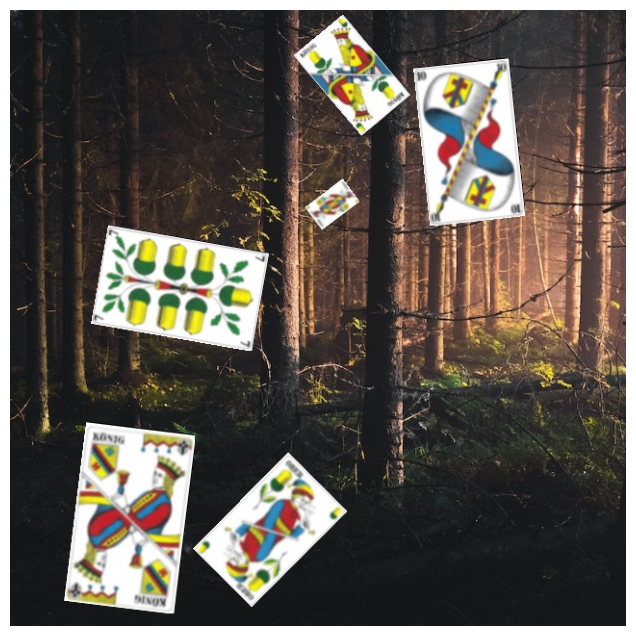

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [8]:
results = model(test_image, show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
The DISPLAY environment variable isn't set.

0: 640x640 1 Eichel 7, 1 Eichel Konig, 1 Eichel Ober, 1 Rose Under, 1 Schilte 10, 1 Schilte Konig, 7.2ms
Speed: 3.6ms preprocess, 7.2ms inference, 429.7ms postprocess per image at shape (1, 3, 640, 640)


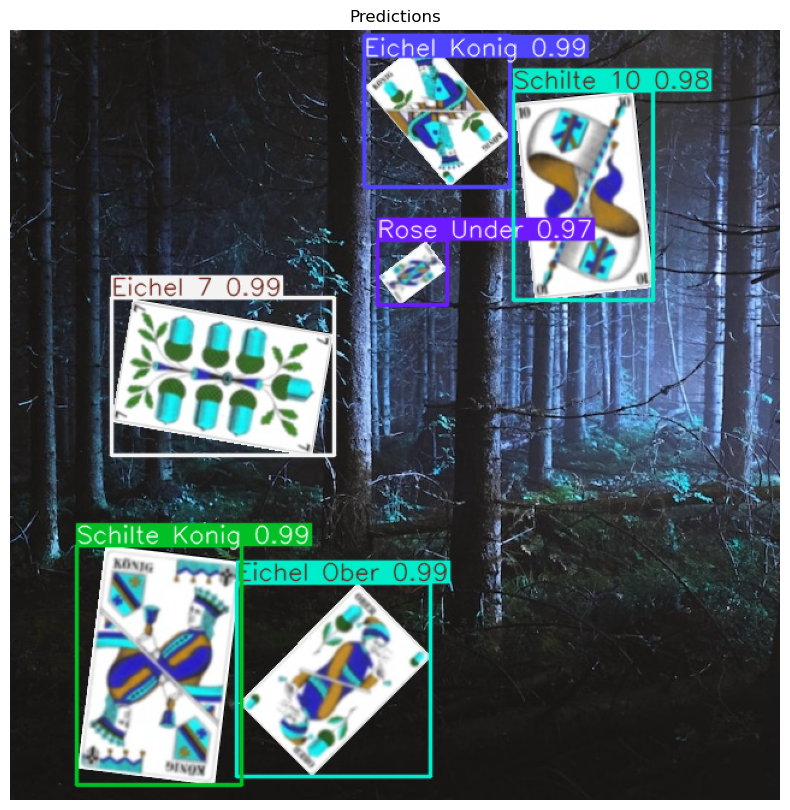

In [9]:
# Get the first result's image with annotations
annotated_img = results[0].plot()  # This returns a NumPy array with boxes drawn

# Show with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img)
plt.axis("off")
plt.title("Predictions")
plt.show()

In [10]:
results = model.predict(source=test_image, conf=0.25)
results[0].show()  # display result for first image


0: 640x640 1 Eichel 7, 1 Eichel Konig, 1 Eichel Ober, 1 Rose Under, 1 Schilte 10, 1 Schilte Konig, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpvveikqws.PNG'
